# Response to article

**Predict**: Upvotes, downvotes, number of comments, length of comments, ...

**Plus**: Interpretable model

See [summary](#summary) at the end.

In [1]:
%matplotlib inline
import re
from time import time
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
# Not necessary, but I like the ggplot style better
plt.style.use('ggplot')
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
df_art = pd.read_csv('articles_2017_09.csv')#.sample(1000)
df_com = pd.read_csv('comments_2017_09.csv')#.sample(100000) # crop because battery life
# Make float better readable
pd.options.display.float_format = '{:.3f}'.format

In [2]:
from datetime import datetime

def get_dt_obj(time):
    time = time.replace('am ', '')
    # Make datetime object from string
    return datetime.strptime(time, '%d.%m.%Y %H:%M')

def time_since_epoch(time):
    return ((time)-datetime(1970,1,1)).total_seconds()

def get_hour_of_day(time):
    return (time).hour

def get_weekday(time):
    return (time).weekday()

df_com['time_dt'] = df_com['time'].apply(get_dt_obj)
df_com['time_since_epoch'] = df_com['time_dt'].apply(time_since_epoch)
df_com['hour'] = df_com['time_dt'].apply(get_hour_of_day)
df_com['weekday'] = df_com['time_dt'].apply(get_weekday) # 0 = Monday
df_com['is_answer'] = df_com['tit'].apply(lambda x: str(x).startswith('@'))
df_com['con_len'] = df_com['con'].apply(lambda x: len(x))
df_com['con_num_words'] = df_com['con'].apply(lambda x: len(x.split()))
df_com['score'] = df_com['vup'] - df_com['vdo']
df_com['activity'] = df_com['vup'] + df_com['vdo']

df_com['tit'] = df_com['tit'].str.lower()
df_com['con'] = df_com['con'].str.lower()

def get_category(link):
    t = link.split('/')
    if len(t) <= 1:
        return ''
    else:
        return t[1]

df_art['cat'] = df_art['link'].apply(get_category)
df_art['cat_copy'] = df_art['cat']
df_art = pd.get_dummies(df_art, columns=['cat'])

df_art['header_len'] = df_art['header'].apply(lambda x: len(x))
df_art['text_len'] = df_art['text'].apply(lambda x: len(str(x)))
df_art['text_num_words'] = df_art['text'].apply(lambda x: len(str(x).split()))
df_art['text_n_periods'] = df_art['text'].apply(lambda x: len(str(x).split('.')))

# Left inner join
df_merge = pd.merge(left=df_com, right=df_art, left_on='tId', right_on='tId')

# Remove rows with missing values
# use .count() to check for missing values
df_merge.dropna(axis=0, how='any', inplace=True)

# Get order of comments per article
df_merge = df_merge.sort_values(['tId', 'time_since_epoch']).groupby('tId')

# Get article specific statistics, group = article
def get_art_statistics(group):
    first = group.iloc[:1]['time_since_epoch']
    group['art_first_weekday'] = group.iloc[:1]['weekday']
    group['art_first_hour'] = group.iloc[:1]['hour']

    group['time_since_first'] = group['time_since_epoch'].apply(lambda x: (x - first) / 3600)

    group['art_score_sum'] = group['score'].sum()
    group['art_activity_sum'] = group['activity'].sum()
    
    return group

df_merge = df_merge.apply(get_art_statistics)
df_merge = df_merge.groupby('tId').mean().reset_index()
df_merge = df_merge.merge(df_art[['tId', 'header', 'sub', 'text']], on='tId')
df_merge.head(2)[['score', 'num_comments', 'header', 'con_len']]

,score,num_comments,header,con_len
0,110.905,21.000,Was steckt hinter der Black-Death-Gruppe?,201.238
1,49.123,73.000,Tunesier lesen Aeschi nach Töff-Panne auf,181.479


In [83]:
#import math

temp2 = pd.get_dummies(df_merge[['tId', 'art_first_weekday']], prefix='art_wd_', columns=['art_first_weekday'])
# Merge here first because of index!
df = df_merge.merge(temp2, on='tId') 
#temp2 = pd.get_dummies(df_merge[['cId', 'hour']], prefix='hour_', columns=['hour'])
#df = df.merge(temp2, left_index=True, right_index=True) 

df = df.drop(['cat_playview', 'cat_play'], axis=1)
#def sgn(x):
#    if x == 0: return 0
#    else: return x/abs(x)
# Removes left/right skew 
#for col in ['weekday_fl', 'con_len', 'text_len', 'time_since_first', 
#            'num_comments', 'user_n_comments', 'con_n_periods',
#            'score', 'contr', 'header_len', 'con_num_words', 'text_num_words']:
#    df[col + '_trans'] = df[col].apply(lambda x: sgn(x)*math.log(abs(x) + 1))

# Memory optimization
# Technical stuff, contributes nothing to analysis
conv = df.select_dtypes(include=['int']).apply(pd.to_numeric,downcast='unsigned')
df[conv.columns] = conv
    
# Get pearson co-efficients
df.corr()

,tId,mob,vup,vdo,time_since_epoch,hour,weekday,is_answer,con_len,con_num_words,...,time_since_first,art_score_sum,art_activity_sum,art_wd__0.0,art_wd__1.0,art_wd__2.0,art_wd__3.0,art_wd__4.0,art_wd__5.0,art_wd__6.0
tId,1.000,-0.019,-0.007,-0.022,-0.028,-0.021,0.007,-0.019,-0.032,-0.035,...,-0.003,-0.017,-0.018,0.009,-0.001,-0.019,0.007,-0.007,0.016,-0.002
mob,-0.019,1.000,0.055,0.049,0.078,0.069,0.154,0.406,-0.229,-0.226,...,-0.063,0.039,0.049,-0.046,-0.040,-0.046,-0.058,0.009,0.142,0.090
vup,-0.007,0.055,1.000,0.619,0.043,0.082,0.017,-0.106,0.063,0.061,...,-0.018,0.401,0.324,0.012,-0.002,-0.039,-0.010,0.041,-0.011,0.015
vdo,-0.022,0.049,0.619,1.000,0.040,0.070,0.047,0.016,0.050,0.051,...,-0.004,0.154,0.218,-0.003,-0.014,-0.048,-0.010,0.054,0.002,0.031
time_since_epoch,-0.028,0.078,0.043,0.040,1.000,0.028,0.019,0.200,-0.085,-0.081,...,-0.144,0.062,0.067,0.002,-0.024,-0.011,0.005,0.015,0.006,0.011
hour,-0.021,0.069,0.082,0.070,0.028,1.000,0.062,0.035,-0.144,-0.145,...,-0.004,-0.039,-0.035,-0.009,-0.022,-0.034,0.005,-0.036,0.062,0.059
weekday,0.007,0.154,0.017,0.047,0.019,0.062,1.000,0.111,-0.035,-0.037,...,0.010,0.008,0.023,-0.597,-0.407,-0.142,0.141,0.359,0.461,0.324
is_answer,-0.019,0.406,-0.106,0.016,0.200,0.035,0.111,1.000,0.078,0.078,...,0.001,0.138,0.227,-0.013,-0.037,-0.048,-0.043,-0.006,0.119,0.071
con_len,-0.032,-0.229,0.063,0.050,-0.085,-0.144,-0.035,0.078,1.000,0.992,...,0.033,0.184,0.190,-0.009,0.024,0.014,0.040,-0.011,-0.044,-0.034
con_num_words,-0.035,-0.226,0.061,0.051,-0.081,-0.145,-0.037,0.078,0.992,1.000,...,0.031,0.184,0.192,-0.007,0.019,0.019,0.043,-0.010,-0.045,-0.040


total data:  2661



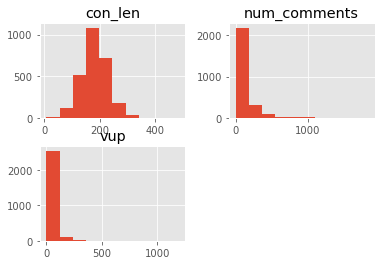

In [84]:
# https://de.wikipedia.org/wiki/Liste_der_h%C3%A4ufigsten_W%C3%B6rter_der_deutschen_Sprache
stop_words = "die, der, und, in, zu, den, das, nicht, von, sie, ist, des, sich, mit, dem, dass, er, es, ein, ich, auf, so, eine, auch, als, an, nach, wie, im, für, "
stop_words += "man, aber, aus, durch, wenn, nur, war, noch, werden, bei, hat, wir, was, wird, sein, einen, welche, sind, oder, zur, um, haben, einer, mir, über, ihm, diese, einem, ihr, uns, "
stop_words += "da, zum, kann, doch, vor, dieser, mich, ihn, du, hatte, seine, mehr, am, denn, nun, unter, sehr, selbst, schon, hier, im,"
stop_words += "bis, habe, ihre, dann, ihnen, seiner, alle, wieder, meine, Zeit, gegen, vom, ganz, einzelnen, wo, muss, ohne, eines, können, sei"
stop_words = stop_words.lower()
stop_words = stop_words.split(', ')

# for content length we want some min. of comments, because con_len is a mean
#df = df[df['num_comments']>=10] 
# num_comments, remove outliers
#df = df[df['num_comments']<400]

df2 = df.drop(['score', 'activity', 'vup', 'vdo', 'num_comments', 
                'art_score_sum'], axis=1)
X = df2
y = df['num_comments']


#y = df['con_len']
#y = df['vup']

from sklearn.model_selection import train_test_split, learning_curve
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
print("total data: ", len(X))

def plot_learning_curve(estimator, X, y, cv=None, ylim=None, n_jobs=1, train_sizes=np.linspace(.5, 1.0, 2)):
    plt.figure()
    plt.title('Learning curve')
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel('Training examples'); plt.ylabel('Score')
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

columns = list(set(['mob', 'time_since_epoch', 'hour', #'weekday', #'is_answer', 'con_len', 'con_num_words', 
           'updated', 'cat_ausland', 'cat_auto', 'cat_community', 'cat_digital', 'cat_entertainment', 'cat_finance', 'cat_fitness', 'cat_leben', 'cat_native', 'cat_panorama', 'cat_people', 'cat_schweiz', 'cat_sport', 'cat_wissen', 'header_len', 'text_len', 'text_num_words', 'cat_ausland', 'cat_auto', 'cat_community', 'cat_digital', 'cat_entertainment', 'cat_finance', 'cat_fitness', 'cat_leben', 'cat_native', 'cat_panorama', 'cat_people', 'cat_schweiz', 'cat_sport', 'cat_wissen', 'cat_ausland', 'cat_auto', 'cat_community', 'cat_digital', 'cat_entertainment', 'cat_finance', 'cat_fitness', 'cat_leben', 'cat_native', 'cat_panorama', 'cat_people', 'cat_schweiz', 'cat_sport', 'cat_wissen', 'cat_ausland', 'cat_auto', 'cat_community', 'cat_digital', 'cat_entertainment', 'cat_finance', 'cat_fitness', 'cat_leben', 'cat_native', 'cat_panorama', 'cat_people', 'cat_schweiz', 'cat_sport', 'cat_wissen', 'cat_ausland', 'cat_auto', 'cat_community', 'cat_digital', 'cat_entertainment', 'cat_finance', 'cat_fitness', 'cat_leben', 'cat_native', 'cat_panorama', 'cat_people', 'cat_schweiz', 'cat_sport', 'cat_wissen', 'cat_ausland', 'cat_auto', 'cat_community', 'cat_digital', 'cat_entertainment', 'cat_finance', 'cat_fitness', 'cat_leben', 'cat_native', 'cat_panorama', 'cat_people', 'cat_schweiz', 'cat_sport', 'cat_wissen', 'cat_ausland', 'cat_auto', 'cat_community', 'cat_digital', 'cat_entertainment', 'cat_finance', 'cat_fitness', 'cat_leben', 'cat_native', 'cat_panorama', 'cat_people', 'cat_schweiz', 'cat_sport', 'cat_wissen', 'cat_ausland', 'cat_auto', 'cat_community', 'cat_digital', 'cat_entertainment', 'cat_finance', 'cat_fitness', 'cat_leben', 'cat_native', 'cat_panorama', 'cat_people', 'cat_schweiz', 'cat_sport', 'cat_wissen', 'cat_ausland', 'cat_auto', 'cat_community', 'cat_digital', 'cat_entertainment', 'cat_finance', 'cat_fitness', 'cat_leben', 'cat_native', 'cat_panorama', 'cat_people', 'cat_schweiz', 'cat_sport', 'cat_wissen',
           'text_n_periods', 'art_first_weekday', 'art_first_hour', 'time_since_first', 'art_wd__0.0', 'art_wd__1.0', 'art_wd__2.0', 'art_wd__3.0', 'art_wd__4.0', 'art_wd__5.0', 'art_wd__6.0']))
# "art_activity_sum", "con_len", "con_num_words"
df.hist(['num_comments', 'con_len', 'vup'])
print()

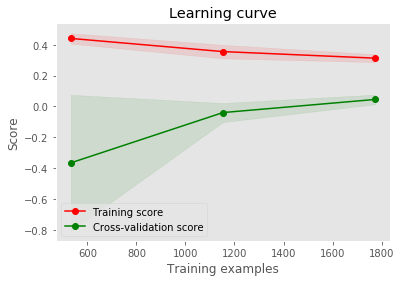

R^2: 0.03
Mean absolute err: 96.73
Mean squared err: 23092.16


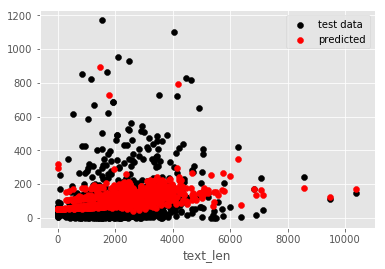

Done in 0.27 min.


In [90]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import r2_score, explained_variance_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest, f_regression, chi2

class ItemSelector(BaseEstimator, TransformerMixin):
    '''
    Select a subset of data at a provided key.
    key: hashable, required
        The key corresponding to the desired value in a mappable.
    '''
    def __init__(self, key):
        self.key = key
        
    def fit(self, x, y=None):
        return self
    
    def transform(self, df):
        return df[self.key]
    
ngram_range = (1, 1)
st = time()
def no_numbers(x):
    return re.sub(r'(\d[\d\.])+', '', x.lower())
model = Pipeline([
    ('union', FeatureUnion(
        [
            ('statistics', Pipeline([
                ('selector', ItemSelector(key=columns)),
              #  ('poly', PolynomialFeatures(degree=2)), # slight increase
                ('scaler', StandardScaler()),
              #  ('reduce_dim', PCA(n_components=30)),
            ])),

            # article text information
            ('header', Pipeline([
                ('selector', ItemSelector(key='header')),
                ('tfidf', TfidfVectorizer(min_df=2, max_df=0.7, preprocessor=no_numbers, ngram_range=ngram_range, stop_words=stop_words)),
               # ('best', TruncatedSVD(n_components=50)),
            ])),
            
            ('subheader', Pipeline([
                ('selector', ItemSelector(key='sub')),
                ('tfidf', TfidfVectorizer(min_df=2, max_df=0.7, preprocessor=no_numbers, ngram_range=ngram_range, stop_words=stop_words)),
            ])),
            
            ('text', Pipeline([
                ('selector', ItemSelector(key='text')),
                ('tfidf', TfidfVectorizer(min_df=0.2, max_df=0.7, preprocessor=no_numbers, ngram_range=ngram_range, stop_words=stop_words)),
            ])),
        ], n_jobs=-1
    )),
    ('reduce_dim', SelectKBest(f_regression, k=30)),
    ('model', LinearRegression(n_jobs=-1))
])

# Just choose what you want to do
if True:
    plot_learning_curve(model, X, y, cv=3, n_jobs=-1,
                       train_sizes=np.linspace(.3, 1.0, 3))
    plt.show()

if True:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print("R^2: %1.2f" % r2_score(y_test, y_pred))
    #print("Explained var: {:3f}".format(explained_variance_score(y_test, y_pred)))
    print("Mean absolute err: {:.2f}".format(mean_absolute_error(y_test, y_pred)))
    print("Mean squared err: {:.2f}".format(mean_squared_error(y_test, y_pred)))
    # Residual plot
    X_res = X_test['text_len']
    plt.scatter(X_res, y_test, color='black', label='test data')
    plt.scatter(X_res, y_pred, color='red', label='predicted')
    plt.xlabel('text_len')
    plt.legend(); plt.show()

if False:
    from sklearn.model_selection import GridSearchCV
    param_grid = {
#        'reduce_dim__score_func': [f_regression, chi2],
        'reduce_dim__k': [20, 30, 40, 50]
#        'model__'
                 }
    grid = GridSearchCV(model, param_grid, cv=3, n_jobs=-1)
    grid.fit(X_train, y_train)

    print(grid.best_params_)
    
print('Done in {:.2f} min.'.format((time() - st)/60))
# Make yourself noticeable to human
#import os; os.system('say "this is dave. the computations are finished."')

In [91]:
# Which features are how important?
# TODO change when using with PolynomialFeatures

# Make a dict with feature=kscore from f_regression
features = {}
i=0
for col in columns:
    features[col] = model.named_steps['reduce_dim'].scores_[i]
    i+=1     
for word in model.named_steps['union'].transformer_list[1][1].named_steps['tfidf'].vocabulary_.keys():
    features['"'+word+'"'] = model.named_steps['reduce_dim'].scores_[i]
    i+=1
for word in model.named_steps['union'].transformer_list[2][1].named_steps['tfidf'].vocabulary_.keys():
    features['"'+word+'"'] = model.named_steps['reduce_dim'].scores_[i]
    i+=1
for word in model.named_steps['union'].transformer_list[3][1].named_steps['tfidf'].vocabulary_.keys():
    features['"'+word+'"'] = model.named_steps['reduce_dim'].scores_[i]
    i+=1
#print(len(model.named_steps['union'].transformer_list[1][1].named_steps['tfidf'].vocabulary_.keys()) )

# Print the best ones
import operator
features_sorted = sorted(features.items(), key=operator.itemgetter(1), reverse=True)
for f, v in features_sorted[:50]:
    print("{}: {:.2f}".format(f, v))

"brasilianische": 67.62
"brauchte": 67.57
cat_finance: 61.92
text_len: 61.62
"welt": 60.22
"stars": 57.56
"platz": 57.12
"tell": 57.12
"fahrer": 57.12
"charlottesville": 57.12
"entdecken": 57.12
"gleise": 57.12
"teilnehmer": 57.12
"schwerer": 57.12
"kims": 53.54
cat_schweiz: 52.80
"radikalen": 51.10
"ungewöhnliche": 46.76
text_num_words: 46.42
"jagt": 42.50
"seit": 39.14
"orten": 36.88
"up": 36.02
text_n_periods: 36.01
"seltene": 35.60
"vorgehen": 34.98
"kilometer": 33.99
"gerissen": 33.93
"helikopter": 32.94
"einsatz": 32.86
"plant": 32.67
"leuteneggers": 31.40
"entschied": 31.20
"bezogen": 29.54
"testet": 29.30
"multiplex": 29.07
"erinnert": 28.98
"schweigen": 28.19
"mitarbeiter": 27.38
"spacex": 26.85
"nationalrat": 26.85
"gestört": 26.85
"lehre": 26.45
"aliexpress": 25.72
"lidl": 24.30
"schlechte": 24.25
"berge": 24.23
"raser": 24.19
"ex": 23.26
"denen": 21.08


<a id="summary"></a>

### Summary

The articles with the most comments also get the highest "art_activity_sum", "is_answer", "con_len" and "con_num_words". This probably means that people are engaging into discussions and then write a lot of comments. Removing those columns from the training data makes the score of the model quite worse. 

#### Number of comments
The features above seem to provoke comments. Please note that most comments seem to happen in the categories "finance" and "schweiz" and that the text length also has an influence.  
Some articles seem to have gotten a lot of comments.

#### Length of comments
Most important feature is text length. Then if people are answering from mobile, category "people", "schweiz" and "sport", also the length of the header plays a role.

#### Highest median upvotes
Score is too bad.

#### In general
More data or complexer model needed...